# Load reannotation results

In [238]:
import glob
import pandas as pd

import sys
sys.path.append('../..')
from ColumnNames import IRRELEVANT_COLS

HOST_NAMES = [
    'kaggle_r1',
    'hp_r1',
    'origin_r1',
    'hp_smt_r1',
    'origin_smt_r1',
]


all_hosts_results = []
for host_name in HOST_NAMES:
    partial_result_filepaths = glob.glob(f'reannotation_results/*{host_name}*.csv')
    partial_results = [pd.read_csv(filepath) for filepath in partial_result_filepaths]
    merged_host_results = pd.concat(partial_results).sort_values(by='LudRules')
    
    merged_host_results = merged_host_results.drop_duplicates(subset=['LudRules']).sort_values(by='LudRules')
    merged_host_results = merged_host_results.drop(columns=IRRELEVANT_COLS, errors='ignore')
    
    all_hosts_results.append(merged_host_results)

    print(f'{host_name} has {len(merged_host_results)} results')

kaggle_r1 has 1845 results
hp_r1 has 1852 results
origin_r1 has 1853 results
hp_smt_r1 has 1852 results
origin_smt_r1 has 1208 results


# Load original features

In [239]:
import polars as pl

organizer_df = pl.read_csv('../from_organizers/train.csv').to_pandas()
organizer_df = organizer_df.drop_duplicates(subset=['LudRules']).sort_values(by='LudRules')
organizer_df = organizer_df.drop(columns=IRRELEVANT_COLS, errors='ignore')

organizer_df.shape

(1373, 597)

In [240]:
extra_df = pd.read_csv('../../GAVEL/generated_csvs/complete_datasets/2024-11-25_21-41-25.csv')
extra_df = extra_df.drop_duplicates(subset=['LudRules']).sort_values(by='LudRules')
extra_df = extra_df.drop(columns=IRRELEVANT_COLS, errors='ignore')

extra_df.shape

(484, 598)

# Check which columns have run to run discrepancies

In [241]:
from tqdm import tqdm
from scipy.stats import ttest_ind

cols_differing_with_same_distribution = []
cols_differing_with_different_distribution = []

reannotated_luds = all_hosts_results[0]['LudRules'].unique()
for col_name in tqdm(organizer_df.columns):
    if col_name not in all_hosts_results[1].columns:
        continue
    if col_name == 'LudRules':
        continue

    run_1_luds_to_values = all_hosts_results[0].set_index('LudRules')[col_name].to_dict()
    run_2_luds_to_values = all_hosts_results[1].set_index('LudRules')[col_name].to_dict()
    
    columns_match = True
    for lud in reannotated_luds:
        if lud not in run_2_luds_to_values.keys():
            continue
        
        if run_1_luds_to_values[lud] != run_2_luds_to_values[lud]:
            columns_match = False
            break

    if columns_match:
        continue

    run_1_values = [run_1_luds_to_values[lud] for lud in reannotated_luds if lud in run_1_luds_to_values.keys()]
    run_2_values = [run_2_luds_to_values[lud] for lud in reannotated_luds if lud in run_2_luds_to_values.keys()]

    t_stat, p_val = ttest_ind(run_1_values, run_2_values, equal_var=False)
    if p_val < 0.15:
        cols_differing_with_different_distribution.append(col_name)
    else:
        cols_differing_with_same_distribution.append(col_name)

print('Cols differing with same distribution:', cols_differing_with_same_distribution)
print('Cols differing with different distribution:', cols_differing_with_different_distribution)

  0%|          | 0/597 [00:00<?, ?it/s]

100%|██████████| 597/597 [00:03<00:00, 170.75it/s]

Cols differing with same distribution: ['SwapPlayersDecisionFrequency', 'PassDecisionFrequency', 'ProposeDecisionFrequency', 'AddDecisionFrequency', 'PromotionDecisionFrequency', 'RemoveDecisionFrequency', 'RotationDecisionFrequency', 'StepDecisionFrequency', 'StepDecisionToEmptyFrequency', 'StepDecisionToFriendFrequency', 'StepDecisionToEnemyFrequency', 'SlideDecisionFrequency', 'SlideDecisionToEmptyFrequency', 'SlideDecisionToEnemyFrequency', 'SlideDecisionToFriendFrequency', 'LeapDecisionFrequency', 'LeapDecisionToEmptyFrequency', 'LeapDecisionToEnemyFrequency', 'HopDecisionFrequency', 'HopDecisionMoreThanOneFrequency', 'HopDecisionEnemyToEmptyFrequency', 'HopDecisionFriendToEmptyFrequency', 'HopDecisionFriendToFriendFrequency', 'HopDecisionEnemyToEnemyFrequency', 'HopDecisionFriendToEnemyFrequency', 'FromToDecisionFrequency', 'FromToDecisionWithinBoardFrequency', 'FromToDecisionBetweenContainersFrequency', 'FromToDecisionEmptyFrequency', 'FromToDecisionEnemyFrequency', 'FromToDecis

In [242]:
import numpy as np

cols_differing_due_to_version_diff = []

reannotated_luds = all_hosts_results[0]['LudRules'].unique()
for col_name in tqdm(organizer_df.columns):
    if col_name in cols_differing_with_different_distribution:
        continue
    if col_name in cols_differing_with_same_distribution:
        continue
    if col_name not in all_hosts_results[0].columns:
        continue
    if col_name == 'LudRules':
        continue

    run_1_luds_to_values = all_hosts_results[0].set_index('LudRules')[col_name].to_dict()
    run_2_luds_to_values = organizer_df.set_index('LudRules')[col_name].to_dict()
    
    columns_match = True
    for lud in reannotated_luds:
        if lud not in run_2_luds_to_values.keys():
            continue
        
        if run_1_luds_to_values[lud] != run_2_luds_to_values[lud]:
            columns_match = False
            break

    if columns_match:
        continue

    # original_mean = np.array(list(run_2_luds_to_values.values())).mean()
    # reannotated_mean = np.array(list(run_1_luds_to_values.values())).mean()
    # print(f'{col_name} means (baseline, reannotated):', original_mean, reannotated_mean)

    cols_differing_due_to_version_diff.append(col_name)

print('Cols differing due to Ludii player version discrepancy:', cols_differing_due_to_version_diff)
print('Col count:', len(cols_differing_due_to_version_diff))

100%|██████████| 597/597 [00:01<00:00, 345.60it/s]

Cols differing due to Ludii player version discrepancy: ['MancalaBoard', 'MancalaStores', 'MancalaTwoRows', 'MancalaThreeRows', 'MancalaFourRows', 'MancalaSixRows', 'MancalaCircular', 'AlquerqueBoard', 'AlquerqueBoardWithOneTriangle', 'AlquerqueBoardWithTwoTriangles', 'AlquerqueBoardWithFourTriangles', 'AlquerqueBoardWithEightTriangles', 'ThreeMensMorrisBoard', 'ThreeMensMorrisBoardWithTwoTriangles', 'NineMensMorrisBoard', 'StarBoard', 'CrossBoard', 'KintsBoard', 'PachisiBoard', 'FortyStonesWithFourGapsBoard', 'Sow', 'SowCW', 'SowCCW', 'GraphStyle', 'ChessStyle', 'GoStyle', 'MancalaStyle', 'PenAndPaperStyle', 'ShibumiStyle', 'BackgammonStyle', 'JanggiStyle', 'XiangqiStyle', 'ShogiStyle', 'TableStyle', 'SurakartaStyle', 'TaflStyle', 'NoBoard', 'MarkerComponent', 'StackType', 'Stack', 'Symbols', 'ShowPieceValue', 'ShowPieceState']
Col count: 43


# Check correlations between runs

In [243]:
from scipy.stats import pearsonr

r1_luds = all_hosts_results[0]['LudRules'].unique()
r2_luds = all_hosts_results[1]['LudRules'].unique()
r3_luds = all_hosts_results[2]['LudRules'].unique()
organizer_luds = organizer_df['LudRules'].unique()
consistently_avaliable_luds = list(set(r1_luds) & set(r2_luds) & set(organizer_luds) & set(r3_luds))

filtered_r1_rows = all_hosts_results[0].set_index('LudRules').loc[consistently_avaliable_luds].sort_index()
filtered_r2_rows = all_hosts_results[1].set_index('LudRules').loc[consistently_avaliable_luds].sort_index()
filtered_r3_rows = all_hosts_results[2].set_index('LudRules').loc[consistently_avaliable_luds].sort_index()
filtered_organizer_rows = organizer_df.set_index('LudRules').loc[consistently_avaliable_luds].sort_index()

r1_advantages = filtered_r1_rows['AdvantageP1'].values
r2_advantages = filtered_r2_rows['AdvantageP1'].values
r3_advantages = filtered_r3_rows['AdvantageP1'].values
organizer_advantages = filtered_organizer_rows['AdvantageP1'].values

print(len(consistently_avaliable_luds))
print(r1_advantages.shape, r2_advantages.shape, r2_advantages.shape, organizer_advantages.shape)

1372
(1372,) (1372,) (1372,) (1372,)


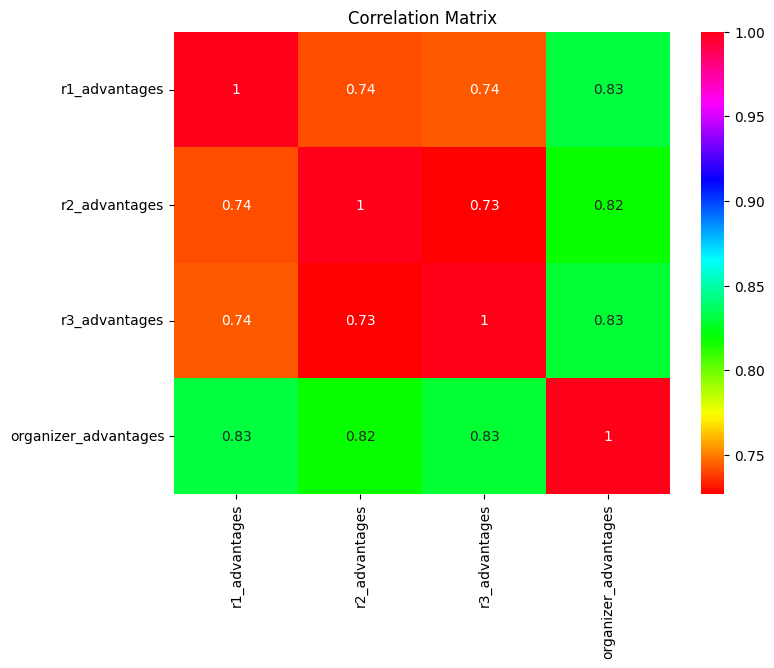

In [245]:
import seaborn as sns
import matplotlib.pyplot as plt

temp_df = pd.DataFrame({
    'r1_advantages': r1_advantages,
    'r2_advantages': r2_advantages,
    'r3_advantages': r3_advantages,
    'organizer_advantages': organizer_advantages
})

corr_matrix = temp_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='hsv')
plt.title('Correlation Matrix')
plt.show()


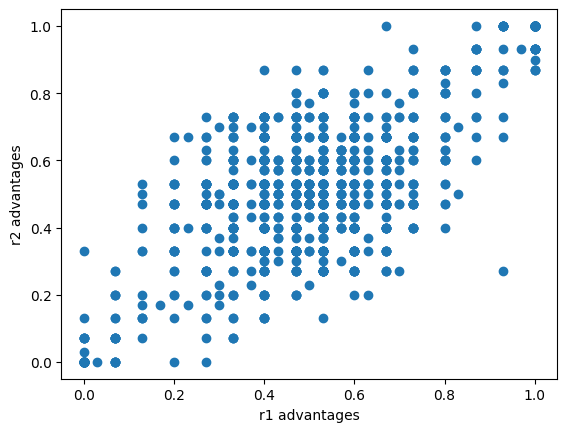

In [246]:
from matplotlib import pyplot as plt

plt.scatter(r1_advantages, r2_advantages)
plt.xlabel('r1 advantages')
plt.ylabel('r2 advantages')

plt.show()

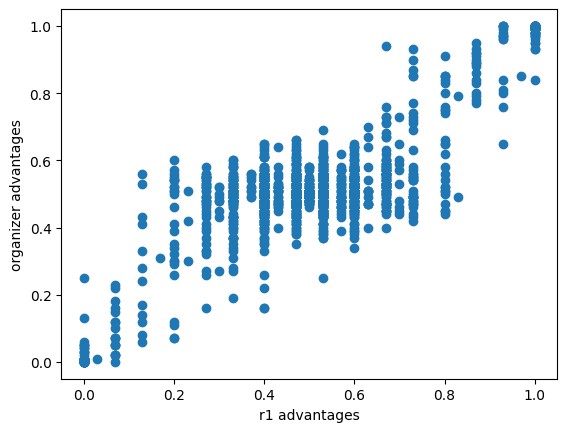

In [247]:
plt.scatter(r1_advantages, organizer_advantages)

plt.xlabel('r1 advantages')
plt.ylabel('organizer advantages')

plt.show()

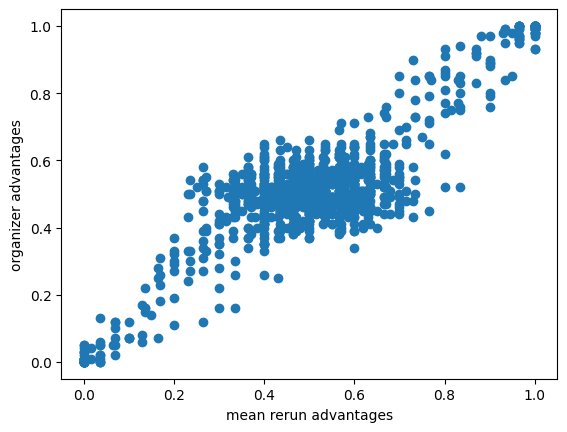

In [248]:
mean_rerun_advantages = (r1_advantages + r2_advantages) / 2

plt.scatter(mean_rerun_advantages, organizer_advantages)
plt.xlabel('mean rerun advantages')
plt.ylabel('organizer advantages')

plt.show()

In [249]:
print(len(np.unique(organizer_advantages)))
print(len(np.unique(r1_advantages)))

print(len(np.unique(organizer_advantages)) / len(np.unique(r1_advantages)))

97
28
3.4642857142857144


# Check speed distributions

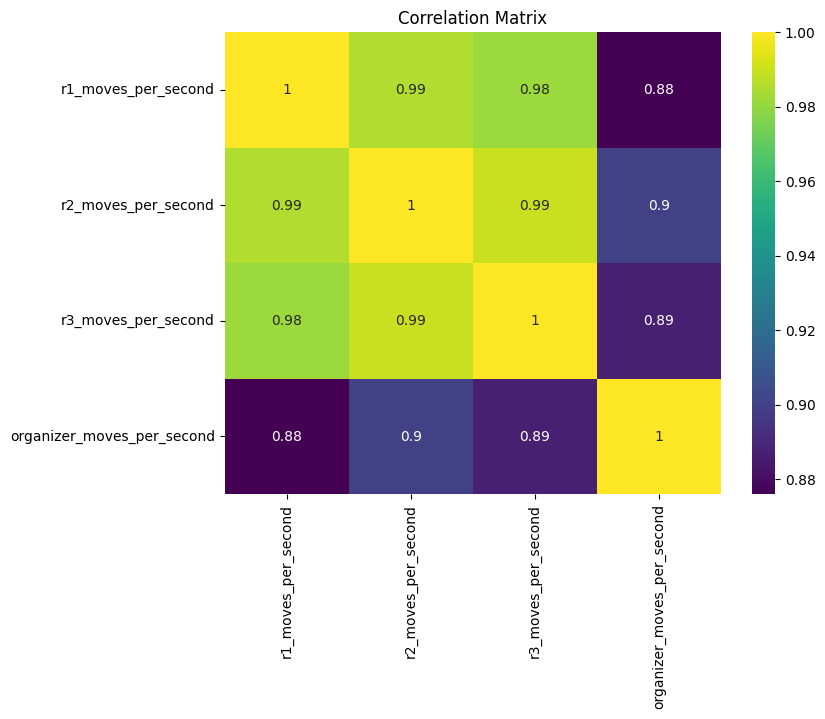

In [250]:
r1_moves_per_second = filtered_r1_rows['MovesPerSecond'].values
r2_moves_per_second = filtered_r2_rows['MovesPerSecond'].values
r3_moves_per_second = filtered_r3_rows['MovesPerSecond'].values
organizer_moves_per_second = filtered_organizer_rows['MovesPerSecond'].values

temp_df = pd.DataFrame({
    'r1_moves_per_second': r1_moves_per_second,
    'r2_moves_per_second': r2_moves_per_second,
    'r3_moves_per_second': r3_moves_per_second,
    'organizer_moves_per_second': organizer_moves_per_second
})

corr_matrix = temp_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title('Correlation Matrix')
plt.show()

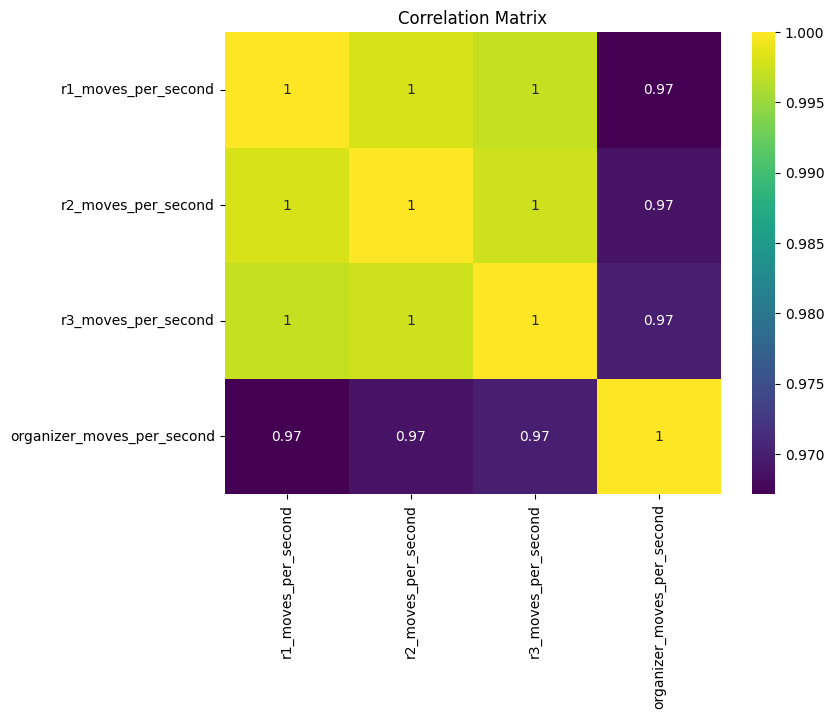

In [251]:
temp_df = pd.DataFrame({
    'r1_moves_per_second': np.log(r1_moves_per_second),
    'r2_moves_per_second': np.log(r2_moves_per_second),
    'r3_moves_per_second': np.log(r3_moves_per_second),
    'organizer_moves_per_second': np.log(organizer_moves_per_second)
})

corr_matrix = temp_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title('Correlation Matrix')
plt.show()

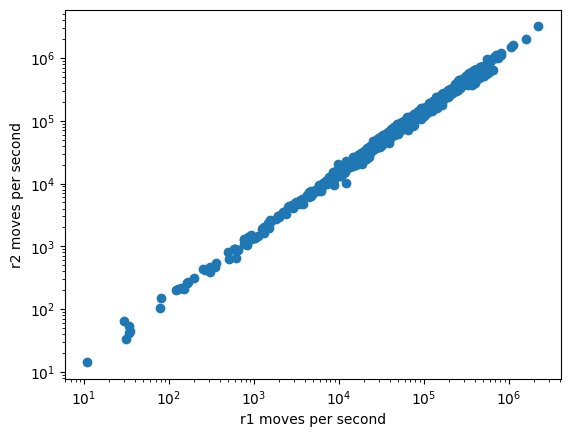

In [252]:
plt.scatter(r1_moves_per_second, r2_moves_per_second)

plt.xlabel('r1 moves per second')
plt.ylabel('r2 moves per second')

plt.xscale('log')
plt.yscale('log')

plt.show()

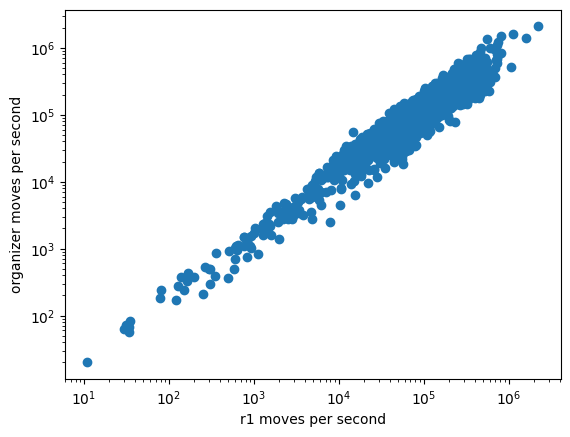

In [253]:
plt.scatter(r1_moves_per_second, organizer_moves_per_second)

plt.xlabel('r1 moves per second')
plt.ylabel('organizer moves per second')

plt.xscale('log')
plt.yscale('log')

plt.show()

In [254]:
print(np.mean(r1_moves_per_second), np.mean(r2_moves_per_second), np.mean(organizer_moves_per_second))

149168.2229664723 209082.55810495623 160126.3894387755


# Form lookup of luds to features to estimates

In [255]:
organizer_luds = organizer_df['LudRules'].unique()
extra_luds = extra_df['LudRules'].unique()

luds_to_features_to_estimates: dict[str, dict[str, list[float]]] = {}
for lud in tqdm(organizer_luds):
    for host_df in all_hosts_results:
        if lud not in host_df['LudRules'].values:
            continue

        host_row = host_df.set_index('LudRules').loc[lud]

        for feature_name in cols_differing_with_same_distribution:
            if lud not in luds_to_features_to_estimates.keys():
                luds_to_features_to_estimates[lud] = {}
            if feature_name not in luds_to_features_to_estimates[lud].keys():
                luds_to_features_to_estimates[lud][feature_name] = []

            luds_to_features_to_estimates[lud][feature_name].append(host_row[feature_name])

for lud in tqdm(extra_luds):
    if lud not in extra_df['LudRules'].values:
        continue

    host_row = extra_df.set_index('LudRules').loc[lud]

    for feature_name in cols_differing_with_same_distribution:
        if lud not in luds_to_features_to_estimates.keys():
            luds_to_features_to_estimates[lud] = {}
        if feature_name not in luds_to_features_to_estimates[lud].keys():
            luds_to_features_to_estimates[lud][feature_name] = []

        luds_to_features_to_estimates[lud][feature_name].append(host_row[feature_name])

100%|██████████| 484/484 [00:01<00:00, 374.07it/s]


In [256]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

for feature_name in cols_differing_with_different_distribution:
    for host_df in all_hosts_results:
        for baseline_df in [organizer_df, extra_df]:
            # RETRIEVE RAW ESTIMATES.
            baseline_luds = baseline_df['LudRules'].unique()
            consistently_available_luds = list(set(host_df['LudRules'].unique()) & set(baseline_luds))
            host_estimates = host_df.set_index('LudRules').loc[consistently_available_luds][feature_name].values
            organizer_estimates = baseline_df.set_index('LudRules').loc[consistently_available_luds][feature_name].values

            # RESCALE HOST ESTIMATES.
            log_host_estimates = np.log(host_estimates)
            log_organizer_estimates = np.log(organizer_estimates)

            model = LinearRegression()
            model.fit(log_host_estimates.reshape(-1, 1), log_organizer_estimates)

            predicted_log_organizer_estimates = model.predict(log_host_estimates.reshape(-1, 1))
            predicted_organizer_estimates = np.exp(predicted_log_organizer_estimates)

            mape = mean_absolute_percentage_error(organizer_estimates, predicted_organizer_estimates)
            print(f'{feature_name} MAPE:', mape)
            # print(f'Means:', np.mean(organizer_estimates), np.mean(predicted_organizer_estimates))
            # print(f'Medians:', np.median(organizer_estimates), np.median(predicted_organizer_estimates))
            # print(f'Mean ratio:', np.mean(organizer_estimates / predicted_organizer_estimates))
            # t, p = ttest_ind(organizer_estimates, predicted_organizer_estimates, equal_var=False)
            # print(f'{feature_name} t-test (t, p):', t, p)

            # RECORD RESCALED ESTIMATES.
            for i, lud in enumerate(consistently_available_luds):
                if lud not in luds_to_features_to_estimates.keys():
                    luds_to_features_to_estimates[lud] = {}
                if feature_name not in luds_to_features_to_estimates[lud].keys():
                    luds_to_features_to_estimates[lud][feature_name] = []

                luds_to_features_to_estimates[lud][feature_name].append(predicted_organizer_estimates[i])

PlayoutsPerSecond MAPE: 0.3380135353314053
PlayoutsPerSecond MAPE: 0.3721104738333725
PlayoutsPerSecond MAPE: 0.33228906064792485
PlayoutsPerSecond MAPE: 0.381654260180104
PlayoutsPerSecond MAPE: 0.3264313765257384
PlayoutsPerSecond MAPE: 0.3624522681130598
PlayoutsPerSecond MAPE: 0.37191974820843493
PlayoutsPerSecond MAPE: 0.3918227288605321
PlayoutsPerSecond MAPE: 0.48588750654564744
PlayoutsPerSecond MAPE: 0.2850277873289252
MovesPerSecond MAPE: 0.33125527421930795
MovesPerSecond MAPE: 0.3760904462473902
MovesPerSecond MAPE: 0.32504505610176154
MovesPerSecond MAPE: 0.3869041947354625
MovesPerSecond MAPE: 0.31965662355121716
MovesPerSecond MAPE: 0.371606240736969
MovesPerSecond MAPE: 0.36586394300215735
MovesPerSecond MAPE: 0.3941335553225216
MovesPerSecond MAPE: 0.46369571211186716
MovesPerSecond MAPE: 0.3100373374420355


In [257]:
sample_lud = list(luds_to_features_to_estimates.keys())[1000]
print(luds_to_features_to_estimates[sample_lud])

organizer_df.set_index('LudRules').loc[sample_lud][cols_differing_with_different_distribution]

{'SwapPlayersDecisionFrequency': [0.0, 0.0, 0.0, 0.0, 0.0], 'PassDecisionFrequency': [0.0, 0.0, 0.0, 0.0, 0.0], 'ProposeDecisionFrequency': [0.0, 0.0, 0.0, 0.0, 0.0], 'AddDecisionFrequency': [1.0, 1.0, 1.0, 1.0, 1.0], 'PromotionDecisionFrequency': [0.0, 0.0, 0.0, 0.0, 0.0], 'RemoveDecisionFrequency': [0.0, 0.0, 0.0, 0.0, 0.0], 'RotationDecisionFrequency': [0.0, 0.0, 0.0, 0.0, 0.0], 'StepDecisionFrequency': [0.0, 0.0, 0.0, 0.0, 0.0], 'StepDecisionToEmptyFrequency': [0.0, 0.0, 0.0, 0.0, 0.0], 'StepDecisionToFriendFrequency': [0.0, 0.0, 0.0, 0.0, 0.0], 'StepDecisionToEnemyFrequency': [0.0, 0.0, 0.0, 0.0, 0.0], 'SlideDecisionFrequency': [0.0, 0.0, 0.0, 0.0, 0.0], 'SlideDecisionToEmptyFrequency': [0.0, 0.0, 0.0, 0.0, 0.0], 'SlideDecisionToEnemyFrequency': [0.0, 0.0, 0.0, 0.0, 0.0], 'SlideDecisionToFriendFrequency': [0.0, 0.0, 0.0, 0.0, 0.0], 'LeapDecisionFrequency': [0.0, 0.0, 0.0, 0.0, 0.0], 'LeapDecisionToEmptyFrequency': [0.0, 0.0, 0.0, 0.0, 0.0], 'LeapDecisionToEnemyFrequency': [0.0, 0.

PlayoutsPerSecond      273.25
MovesPerSecond       15163.83
Name: (game "Pyrga" (players 2) (equipment { (board (square 4) use:Cell) (hand Each size:15) (piece "Disc" Each) (piece "SquareOrtho" Each) (piece "SquareDiag" Each) (piece "TriangleN" Each) (piece "TriangleS" Each) (piece "TriangleE" Each) (piece "TriangleW" Each) } ) (rules (start { (place "Disc1" (handSite P1 0)) (place "Disc1" (handSite P1 1)) (place "Disc1" (handSite P1 2)) (place "Disc1" (handSite P1 3)) (place "Disc1" (handSite P1 4)) (place "SquareOrtho1" (handSite P1 5)) (place "SquareOrtho1" (handSite P1 6)) (place "SquareOrtho1" (handSite P1 7)) (place "SquareOrtho1" (handSite P1 8)) (place "SquareOrtho1" (handSite P1 9)) (place "TriangleN1" (handSite P1 10)) (place "TriangleN1" (handSite P1 11)) (place "TriangleN1" (handSite P1 12)) (place "TriangleN1" (handSite P1 13)) (place "TriangleN1" (handSite P1 14)) (place "Disc2" (handSite P2 0)) (place "Disc2" (handSite P2 1)) (place "Disc2" (handSite P2 2)) (place "Disc2

In [258]:
print(luds_to_features_to_estimates[sample_lud]['AdvantageP1'])
organizer_df.set_index('LudRules').loc[sample_lud]['AdvantageP1']

[0.53, 0.43, 0.47, 0.57, 0.47]


0.56

# Average the estimates

In [259]:
luds_to_features_to_mean_estimates = {}
for lud, features_to_estimates in luds_to_features_to_estimates.items():
    if lud not in luds_to_features_to_mean_estimates.keys():
        luds_to_features_to_mean_estimates[lud] = {}

    for feature, estimates in features_to_estimates.items():
        luds_to_features_to_mean_estimates[lud][feature] = np.mean(estimates)

In [260]:
print(luds_to_features_to_mean_estimates[sample_lud])

organizer_df.set_index('LudRules').loc[sample_lud][cols_differing_with_different_distribution]

{'SwapPlayersDecisionFrequency': 0.0, 'PassDecisionFrequency': 0.0, 'ProposeDecisionFrequency': 0.0, 'AddDecisionFrequency': 1.0, 'PromotionDecisionFrequency': 0.0, 'RemoveDecisionFrequency': 0.0, 'RotationDecisionFrequency': 0.0, 'StepDecisionFrequency': 0.0, 'StepDecisionToEmptyFrequency': 0.0, 'StepDecisionToFriendFrequency': 0.0, 'StepDecisionToEnemyFrequency': 0.0, 'SlideDecisionFrequency': 0.0, 'SlideDecisionToEmptyFrequency': 0.0, 'SlideDecisionToEnemyFrequency': 0.0, 'SlideDecisionToFriendFrequency': 0.0, 'LeapDecisionFrequency': 0.0, 'LeapDecisionToEmptyFrequency': 0.0, 'LeapDecisionToEnemyFrequency': 0.0, 'HopDecisionFrequency': 0.0, 'HopDecisionMoreThanOneFrequency': 0.0, 'HopDecisionEnemyToEmptyFrequency': 0.0, 'HopDecisionFriendToEmptyFrequency': 0.0, 'HopDecisionFriendToFriendFrequency': 0.0, 'HopDecisionEnemyToEnemyFrequency': 0.0, 'HopDecisionFriendToEnemyFrequency': 0.0, 'FromToDecisionFrequency': 0.0, 'FromToDecisionWithinBoardFrequency': 0.0, 'FromToDecisionBetweenCo

PlayoutsPerSecond      273.25
MovesPerSecond       15163.83
Name: (game "Pyrga" (players 2) (equipment { (board (square 4) use:Cell) (hand Each size:15) (piece "Disc" Each) (piece "SquareOrtho" Each) (piece "SquareDiag" Each) (piece "TriangleN" Each) (piece "TriangleS" Each) (piece "TriangleE" Each) (piece "TriangleW" Each) } ) (rules (start { (place "Disc1" (handSite P1 0)) (place "Disc1" (handSite P1 1)) (place "Disc1" (handSite P1 2)) (place "Disc1" (handSite P1 3)) (place "Disc1" (handSite P1 4)) (place "SquareOrtho1" (handSite P1 5)) (place "SquareOrtho1" (handSite P1 6)) (place "SquareOrtho1" (handSite P1 7)) (place "SquareOrtho1" (handSite P1 8)) (place "SquareOrtho1" (handSite P1 9)) (place "TriangleN1" (handSite P1 10)) (place "TriangleN1" (handSite P1 11)) (place "TriangleN1" (handSite P1 12)) (place "TriangleN1" (handSite P1 13)) (place "TriangleN1" (handSite P1 14)) (place "Disc2" (handSite P2 0)) (place "Disc2" (handSite P2 1)) (place "Disc2" (handSite P2 2)) (place "Disc2

# Save the estimates

In [ ]:
import json

# _v1 - Only supports organizer data & v5 extra data. Generated via ensemble of 3 reannotation runs.
# _v1.1 - Added preliminary support for v6 extra data. Extra features computed via 1 full reannotation run + half of a rerun on another machine.
# _v1.2 - Added full support for v6 extra data. Extra features computed via ensemble of 3 reannotation runs.
# _v2.0 - Added results for 2 more runs, this time with all logical cores (instead of just physical). 1 complete + 1 *mostly* complte.
with open('lud_to_features_to_estimates.json', 'w') as f:
    json.dump(luds_to_features_to_mean_estimates, f, indent=4)